# Numerical evaluation of root-finding, topological ordering, and edge pruning

Code by Jacqueline Maasch | April 2024

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import platform
import time
import warnings
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from dowhy import gcm
from dowhy.gcm.util.general import set_random_seed
from os import listdir
from os.path import isfile, join
#import igraph as ig

# Custom scripts.
#from root_id import RootID
import Root_Algo
import path_tracing

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)

python version     : 3.10.13
numpy version      : 1.26.3
pandas version     : 2.1.4
matplotlib version : 3.8.0
seaborn version    : 0.12.2


/Users/jmaasch/anaconda3/envs/icp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define functions

In [2]:
def plot_nx(adjacency_matrix,
            labels,
            figsize = (5,5),
            dpi = 75,
            node_size = 800,
            arrow_size = 10):

    '''
    Plot graph given adjacency matrix.
    '''
    
    g = nx.from_numpy_array(adjacency_matrix, create_using = nx.DiGraph)
    plt.figure(figsize = figsize, dpi = dpi)  
    nx.draw_circular(g, 
                     node_size = node_size, 
                     node_color = "pink",
                     labels = dict(zip(list(range(len(labels))), labels)), 
                     arrowsize = arrow_size,
                     with_labels = True)
    plt.show()
    plt.close()

## Read data

In [3]:
# Erdos-Renyi graphs.
df_5n_5m = pd.read_csv("data/erdos_renyi/erdos_renyi_5n_5m.csv")

In [4]:
display(df_5n_5m.head(10))

X1  X2  X3  X4  X5  Replicate
0   0   1   0   1   1          1
1   0   0   0   1   0          1
2   0   0   0   0   0          1
3   0   0   0   0   1          1
4   0   0   0   0   0          1
5   0   0   1   1   1          2
6   0   0   0   1   0          2
7   0   0   0   1   0          2
8   0   0   0   0   0          2
9   0   0   0   0   0          2

## Process data

In [5]:
# Extract adjacency matrices.
n = 5
df_5n_5m = df_5n_5m.drop(columns = "Replicate")
adj_matrices = [df_5n_5m[i:i+n].to_numpy() for i in range(0,df_5n_5m.shape[0],n)]
adj_matrices

[array([[0, 1, 0, 1, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]]),
 array([[0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 0, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([[0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 1, 0],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0,

array([[0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

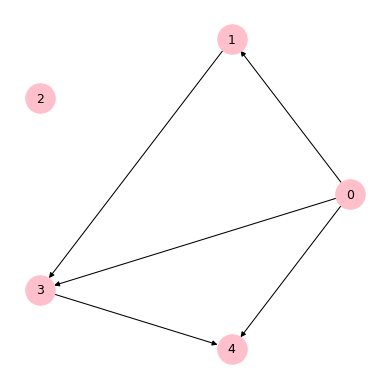

array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

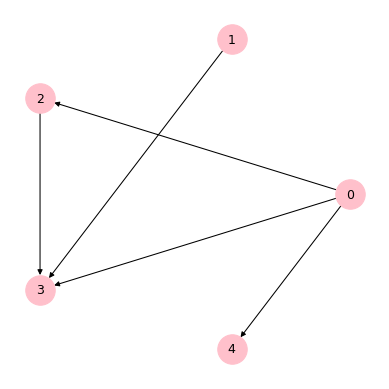

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

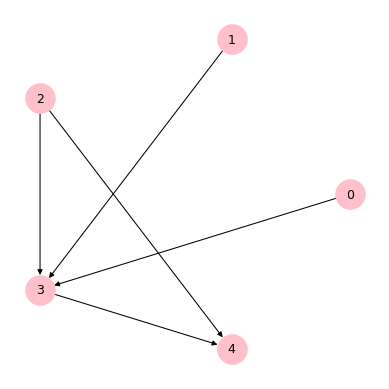

array([[0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

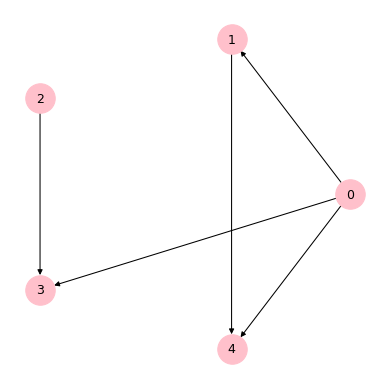

array([[0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

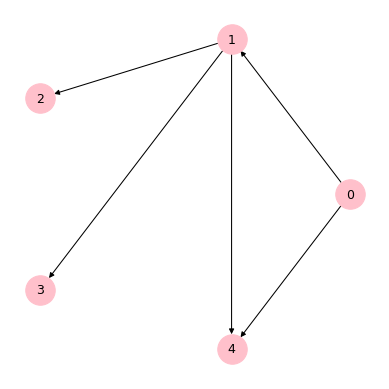

array([[0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

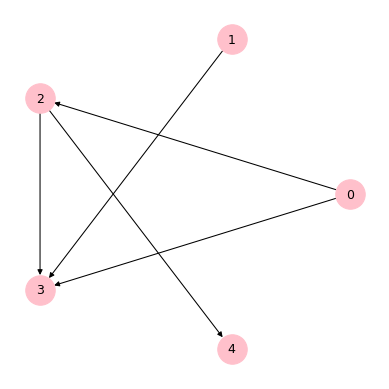

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

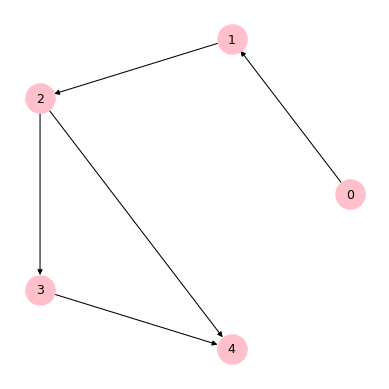

array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

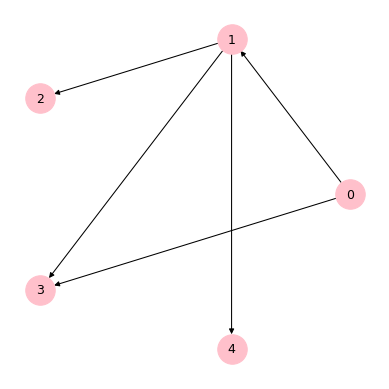

array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

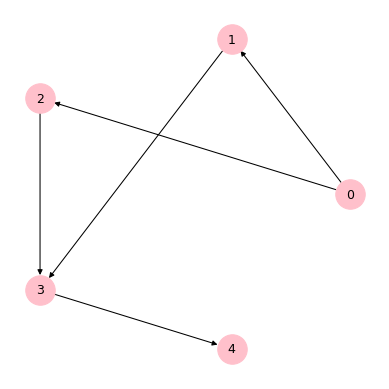

array([[0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

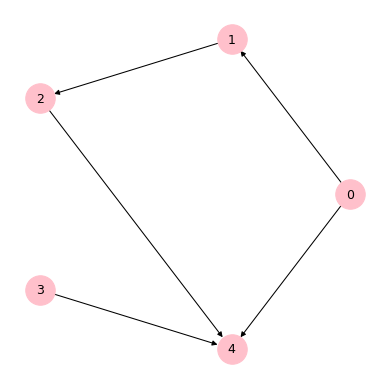

In [6]:
for adj in adj_matrices:
    display(adj)
    plot_nx(adj, labels = range(adj.shape[1]))

## Sample from distribution

In [7]:
# https://www.pywhy.org/dodiscover/dev/auto_examples/plot_pc_alg.html
# https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/customizing_model_assignment.html
class MyCustomModel(gcm.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return self.coefficient * X

    def clone(self):
        # We don't really need this actually.
        return MyCustomModel(self.coefficient)

Fitting causal mechanism of node 4: 100%|████████| 5/5 [00:00<00:00, 687.68it/s]


0         1         2         3         4
0 -0.161924  1.787829 -1.046540  1.343356  3.102487
1 -2.395520 -1.305791  0.612889 -6.416465 -1.062156
2 -1.966613 -1.992202 -0.347577 -3.680996 -0.913874
3  1.068980  1.973419 -1.512564  1.238712 -0.504545
4 -0.501385 -0.632883 -2.572451 -1.176887  0.213046

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1456.86it/s]


0         1         2         3         4
0  0.281740  1.496801 -0.259025 -0.073656  1.978653
1  1.128835  4.538661  1.026233  2.895766  2.731655
2  0.865617  0.671420  4.144432  2.556914  1.743675
3  0.854753 -0.080665  0.281705  0.486508  2.088707
4  0.893215 -0.594873 -0.066139  1.905099  3.726454

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1475.93it/s]


0         1         2         3         4
0  2.191147  2.437907  1.911124  3.562267  3.322958
1  3.609521  1.559301  0.951423  4.391116  2.478015
2  1.602493  0.896359  0.174324  1.220097  0.608010
3  2.364815  3.127680 -0.452195  2.061331  0.889012
4 -0.242575  0.550063  2.785828 -0.143300  3.450670

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1169.57it/s]


0         1         2         3         4
0  0.831267  1.787727  4.329784  0.514697 -1.446987
1 -0.351321  0.483218  0.482548  1.816875 -3.499650
2  1.375147  1.660844  1.471720  2.850736  0.218796
3  0.581852 -0.572098  1.058577 -1.347140 -1.282055
4  1.833110  2.105523  0.908501  2.953081  1.170035

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1150.51it/s]


0         1         2         3         4
0 -2.230379 -1.322066 -1.773441 -0.790657 -4.097046
1 -0.761994  1.271967 -0.018156  0.747161 -0.153350
2 -0.544077  3.094365  2.749326  4.024475  0.417776
3 -0.603772  0.064343 -0.550605  2.047063  1.324001
4  1.049263  1.190911  1.615629  1.591583 -1.620431

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1378.16it/s]


0         1         2         3         4
0 -0.331404  0.549781 -3.828383  1.274324 -2.775911
1 -1.872936  1.763130  1.158918  0.072568  0.388880
2 -0.747487 -1.436057 -0.634792  1.697608 -0.697183
3 -0.059250 -0.741900 -1.122137  2.809406 -0.610798
4 -1.431677  0.428983 -2.163179 -0.848703 -3.108014

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1204.22it/s]


0         1         2         3         4
0  0.804584  0.007408 -1.904826 -1.956701 -3.261993
1  1.238217  4.361609  1.203149  2.119840 -1.101520
2 -0.827991 -2.666266 -3.779165 -6.445128 -6.310491
3  0.162311 -0.207773  0.404049  1.313937  0.268842
4 -0.501661 -0.123976 -2.991861 -3.344000 -2.238033

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1500.00it/s]


0         1         2         3         4
0  1.446670  0.841885  0.019820  0.685110  1.505813
1 -0.543946 -0.198022 -1.326454 -3.312823  0.363631
2 -1.453603 -1.386689 -3.241574 -2.287091 -3.488671
3 -0.233450 -1.121949  1.060529 -0.828246  2.249886
4  1.206439  1.369039  1.583516 -0.903411  1.787623

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1635.08it/s]


0         1         2         3         4
0 -0.158691  0.901683  0.465288  1.954003 -0.880381
1 -0.590915  2.031453 -0.771215  0.226595 -0.265201
2 -0.240346  0.785648  0.481150  0.261384  1.784486
3 -2.891613 -4.445332 -0.376840 -3.678786 -4.676160
4 -1.157361  0.019728  1.352368  0.384749 -1.222652

Success.


Fitting causal mechanism of node 4: 100%|███████| 5/5 [00:00<00:00, 1887.46it/s]


0         1         2         3         4
0 -1.651477 -1.017772  0.994073 -1.718192 -1.939723
1  0.630048  2.868976  3.148434 -1.383040  1.182881
2  2.879607  3.734489  5.113315 -1.160404  3.039257
3  3.684439  4.600313  6.374815 -2.119470  3.585128
4  1.353016  4.892795  7.048446 -0.823824 -0.580888

Success.


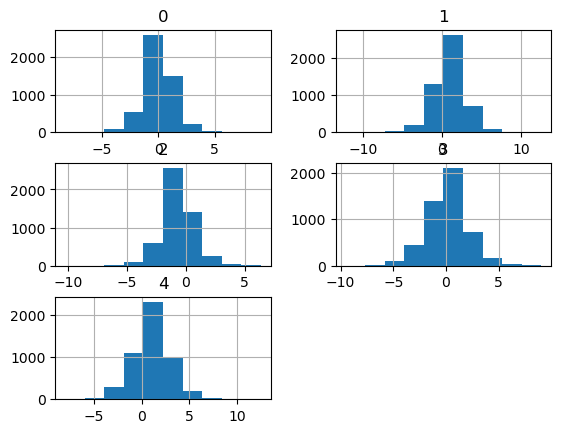

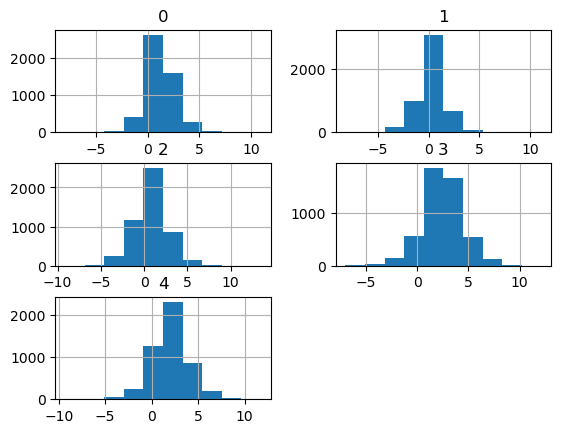

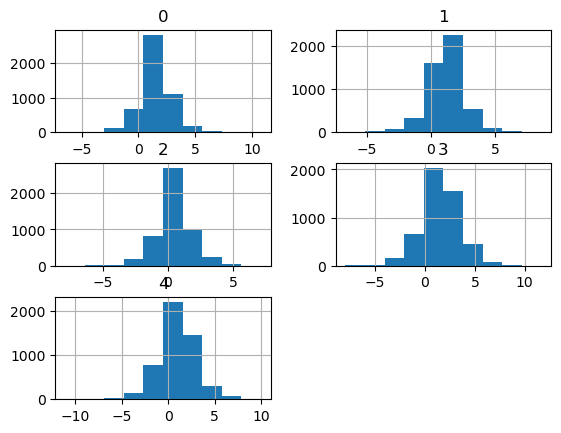

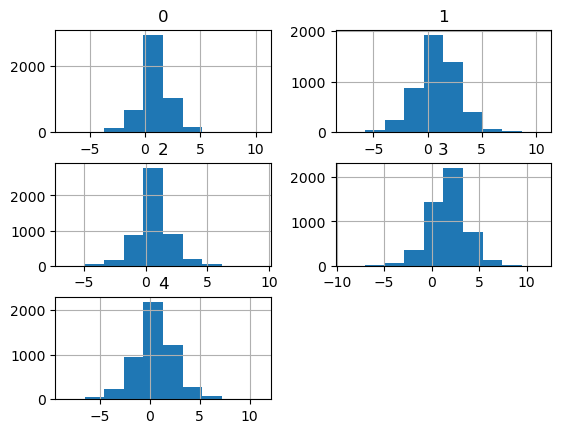

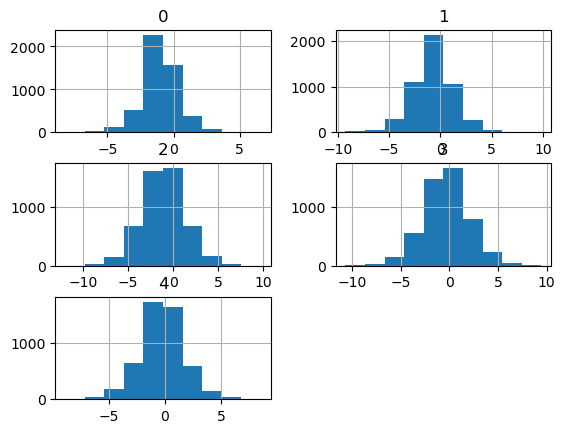

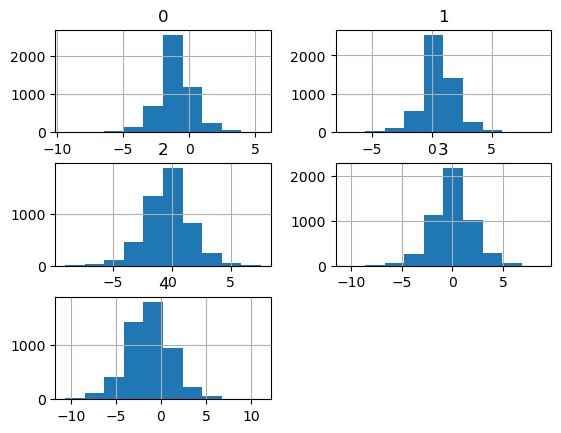

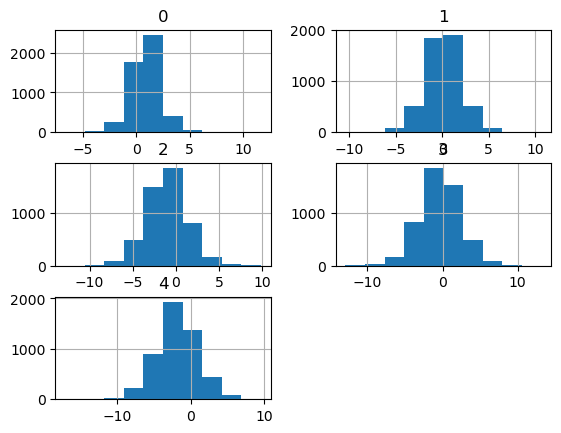

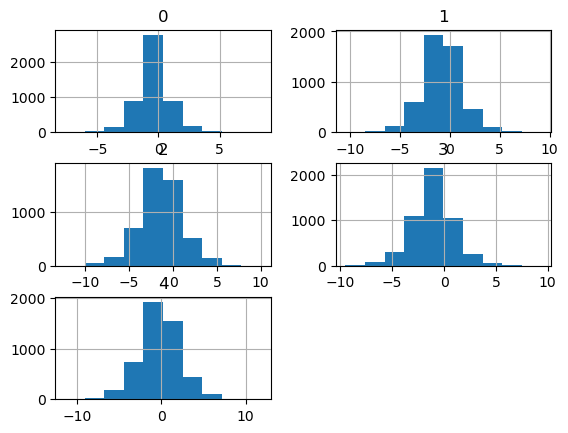

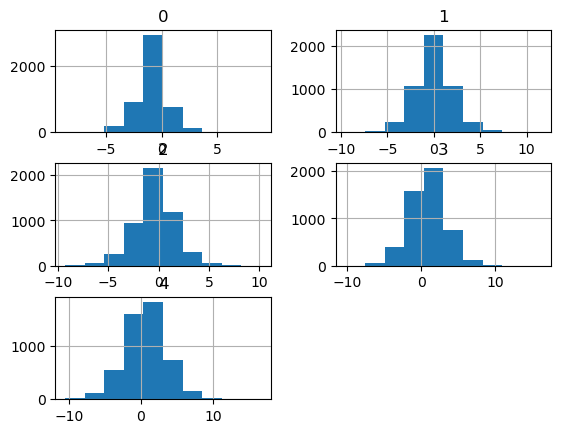

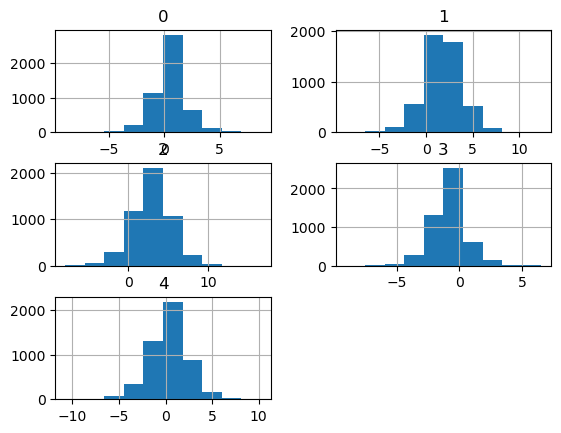

In [8]:
#set_random_seed(1234)

samples = []
roots_true = []
graphs = []
n = 5000
for adj in adj_matrices:

    #display(adj)

    # Identify true roots from adjacency matrix.
    nodes = range(adj.shape[1])
    column_sums = adj.sum(axis = 0)
    root_idx = np.where(column_sums == 0)[0]
    roots_true.append(root_idx)

    # Construct graph from adjacency matrix.
    G = nx.from_numpy_array(adj, create_using = nx.DiGraph)
    node_map = dict(zip(range(adj.shape[1]), nodes))
    G = nx.relabel_nodes(G, node_map, copy = True)
    graphs.append(G)
    #nx.draw_shell(G, 
    #              node_color = "pink",
    #              node_size = 800, 
    #              arrowsize = 10,
    #              with_labels = True)
    #plt.show()
    #plt.close()

    # Define causal model.
    causal_model = gcm.ProbabilisticCausalModel(G)
    params = np.random.uniform(low = -1.2, high = 1.5, size = len(nodes))
    for node,p in zip(nodes,params):
        if node in root_idx:
            #causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(stats.binom, p = p, n = 1))
            causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(stats.laplace, loc = p, scale = 1))
        else:
            causal_model.set_causal_mechanism(
                    node,
                    gcm.AdditiveNoiseModel(
                        #prediction_model = gcm.ml.create_linear_regressor(),
                        prediction_model = MyCustomModel(1),
                        #noise_model = gcm.ScipyDistribution(stats.binom, p = p, n = 1),
                        noise_model = gcm.ScipyDistribution(stats.laplace, loc = p, scale = 1),
                    ),
                )

    # "Fit here would not really fit parameters, since we don't do anything in the fit method.
    # Here, we only need this to ensure that each FCM has the correct local hash (i.e., we
    # get an inconsistency error if we would modify the graph afterwards without updating
    # the FCMs). Having an empty data set is a small workaround, since all models are pre-defined."
    gcm.fit(causal_model, pd.DataFrame(columns = nodes))
    
    # Sample the observational data.
    data = gcm.draw_samples(causal_model, num_samples = n)

    # Columns are shuffled by DoWhy; put back in order w.r.t. order of adjacency matrix.
    data = data[nodes]
    display(data.head())
    data.hist()
    try:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        samples.append(data)
        print("Success.")
    except:
        pass

In [9]:
len(adj_matrices)

## Find roots

### 5 node DAGs


--- 0 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

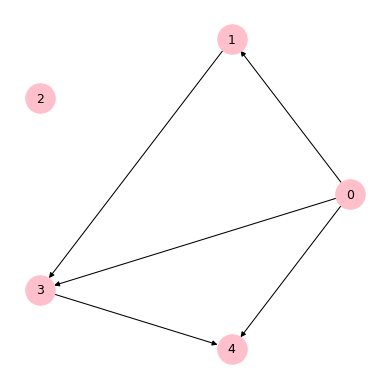


Runtime : 6.842 seconds
Predicted roots : [1, 0, 1, 0, 0]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 1 ---



array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

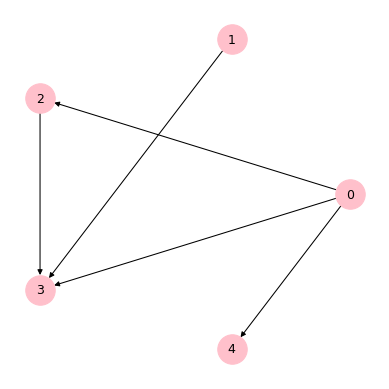


Runtime : 8.358 seconds
Predicted roots : [1, 1, 0, 0, 0]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 2 ---



array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

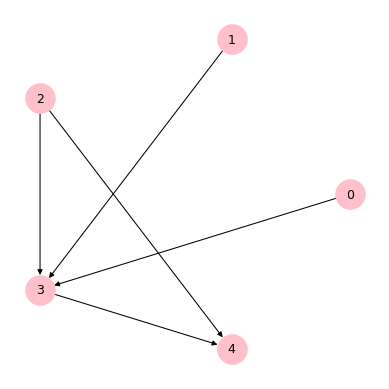


Runtime : 7.292 seconds
Predicted roots : [1, 1, 1, 0, 0]
True roots      : [1, 1, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 3 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

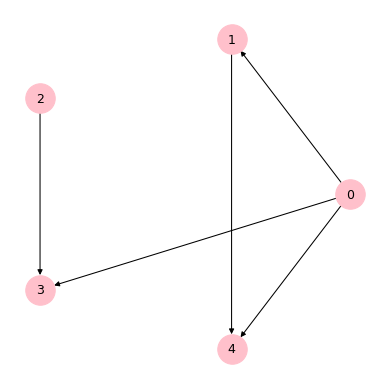


Runtime : 8.489 seconds
Predicted roots : [1, 0, 1, 0, 0]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 4 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

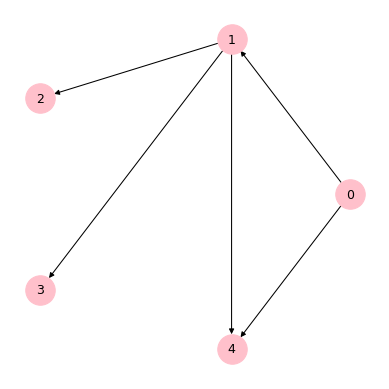


Runtime : 8.808 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 5 ---



array([[0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

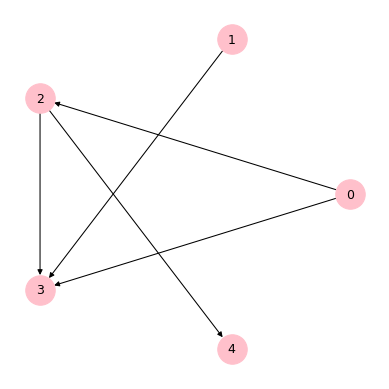


Runtime : 6.959 seconds
Predicted roots : [1, 1, 0, 0, 0]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 6 ---



array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

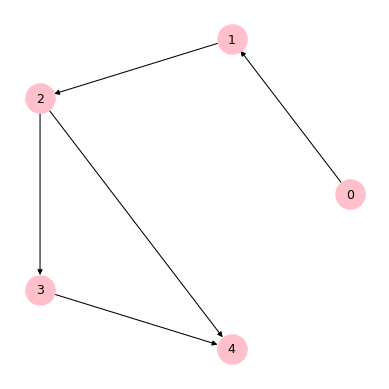


Runtime : 8.219 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 7 ---



array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

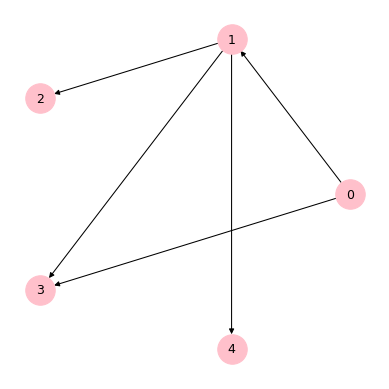


Runtime : 8.452 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 8 ---



array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

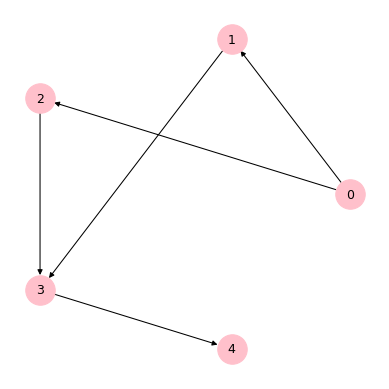


Runtime : 7.856 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 9 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

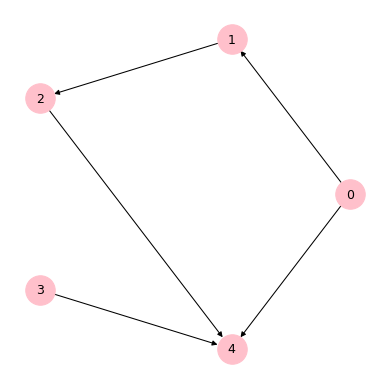


Runtime : 7.722 seconds
Predicted roots : [1, 0, 0, 1, 0]
True roots      : [1, 0, 0, 1, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

Mean accuracy  : 1.0
Mean F1        : 1.0
Mean precision : 1.0
Mean recall    : 1.0


In [10]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i in range(len(samples)):
    print("\n---", i, "---\n")
    display(adj_matrices[i])
    plot_nx(adj_matrices[i], labels = range(5))

    # Scale data.
    scaler = StandardScaler()
    data = scaler.fit_transform(samples[i])

    # Run root-finding.
    start = time.time()
    roots, marg_ind = Root_Algo.root_detection(data, alpha = 0.001)
    print("\nRuntime :", round(time.time() - start, 3), "seconds")

    # Evaluate performance.
    true_roots = [1 if j in roots_true[i] else 0 for j in range(adj_matrices[i].shape[0])]
    pred_roots = [1 if j in roots else 0 for j in range(adj_matrices[i].shape[0])]
    accuracy = accuracy_score(true_roots, pred_roots)
    accuracy_scores.append(accuracy)
    f1 = f1_score(true_roots, pred_roots)
    f1_scores.append(f1)
    precision = precision_score(true_roots, pred_roots)
    precision_scores.append(precision)
    recall = recall_score(true_roots, pred_roots)
    recall_scores.append(recall)
    
    print("Predicted roots :", pred_roots)
    print("True roots      :", true_roots)
    print("Accuracy        :", accuracy)
    print("F1              :", f1)
    print("Precision       :", precision)
    print("Recall          :", recall)

print("\nMean accuracy  :", np.mean(accuracy_scores))
print("Mean F1        :", np.mean(f1_scores))
print("Mean precision :", np.mean(precision_scores))
print("Mean recall    :", np.mean(recall_scores))

## Edge pruning

In [12]:
parents_correct_total = 0
children_correct_total = 0

for data,graph in zip(samples,graphs):
    true_sort = list(nx.topological_sort(graph))
    start = time.time()
    pred_parents, pred_children = path_tracing.path_tracing(true_sort, data, alpha = 0.001)
    print("\nPath tracing complete in {}s.".format(round(time.time() - start, 4)))

    true_parents_sets = []
    true_children_sets = []
    for j in range(adj.shape[0]):
        true_parents = set(np.where(adj[:,j] == 1)[0])
        true_parents_sets.append(true_parents)
        true_children = set(np.where(adj[j,:] == 1)[0])
        true_children_sets.append(true_children)

    parents_correct = all([x == y for x,y in zip(true_parents_sets,pred_parents)])
    parents_correct_total += parents_correct
    children_correct = all([x == y for x,y in zip(true_children_sets,pred_children)])
    children_correct_total += children_correct

    print("True parents       :", true_parents_sets)
    print("Predicted parents  :", pred_parents)
    print("Parents correct    :", parents_correct)
    print("True children      :", true_children_sets)
    print("Predicted children :", pred_children)
    print("Children correct   :", children_correct)

print("\nTotal parents correct  :", parents_correct_total)
print("Total children correct :", children_correct_total)


Path tracing complete in 0.0092s.
True parents       : [set(), {0}, {1}, set(), {0, 2, 3}]
Predicted parents  : [set(), {0}, set(), {0}, {0}]
Parents correct    : False
True children      : [{1, 4}, {2}, {4}, {4}, set()]
Predicted children : [{1, 3, 4}, set(), set(), set(), set()]
Children correct   : False

Path tracing complete in 0.0073s.
True parents       : [set(), {0}, {1}, set(), {0, 2, 3}]
Predicted parents  : [set(), set(), {0}, {0}, {0}]
Parents correct    : False
True children      : [{1, 4}, {2}, {4}, {4}, set()]
Predicted children : [{2, 3, 4}, set(), set(), set(), set()]
Children correct   : False

Path tracing complete in 0.0029s.
True parents       : [set(), {0}, {1}, set(), {0, 2, 3}]
Predicted parents  : [set(), set(), set(), {0}, {2}]
Parents correct    : False
True children      : [{1, 4}, {2}, {4}, {4}, set()]
Predicted children : [{3}, set(), {4}, set(), set()]
Children correct   : False

Path tracing complete in 0.0052s.
True parents       : [set(), {0}, {1}, se

## End of document